In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy 
from itertools import product,combinations
from time import time 
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#from utils import read_data,label_mapping_FEMNIST
from utils import *
from models import Net, Federated_Averaging, Global_Model,Local_Model,AFPL,training_loop
from data import FEMNIST_dataset, Partition_MNIST_NIID,MNIST_NIID_dataset
import keras

import yaml 
stream = 'settings\train_settings.yaml'
with open('settings/train_settings.yaml','r') as file:
    settings = yaml.safe_load(file)
    
print(settings)
### Divide MNIST dataset over a total of 10 clients. Each client gets 2 classes.
train_data, test_data = keras.datasets.mnist.load_data()
instance = Partition_MNIST_NIID(train_data[0],train_data[1])
classes_per_user = 2
total_clients = 12
train_partition = instance.create_partition(4,classes_per_user,total_clients)
test_instance = Partition_MNIST_NIID(test_data[0], test_data[1])
test_partition = test_instance.create_partition_test(instance.sample_array)

2023-03-16 12:58:15.054127: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'experiment_name': 'test_adaptive_a4', 'Date': '22_11_2022', 'Dataset': 'MNIST_niid', 'n_clients': 10, 'total_clients': 10, 'classes_per_user': 10, 'network': 'Net', 'n_epochs': 100, 'local_iterations': 1, 'type': 'afpl', 'log_interval': 25}
[[1 2]
 [0 1]
 [0 1]
 [3 1]
 [3 0]
 [0 1]
 [0 1]
 [3 2]
 [0 2]
 [3 1]
 [1 2]
 [0 1]]


In [3]:
# SHAP kernel 

class SHAP_kernel(object): 
    def __init__(self,n_clients,samples,verbose=True):
        self.samples = samples 
        self.n_clients = n_clients 
        self.verbose = verbose 
        self.indices = []
        
    def first_guess(self): 
        self.shap_weights = [(self.n_clients-1)/(z*(self.n_clients-z)) for z in list(range(1,self.n_clients))]
        self.discrete_shap = np.round(self.shap_weights/np.sum(self.shap_weights)*self.samples)
        
    def adjust_if_necessary(self,shap_kernel):
        ddd = copy.copy(shap_kernel)
        
        self.changed = False 
        for i,ele in enumerate(shap_kernel):
            if i not in self.indices: 
                binom_i = binom(len(shap_kernel)+1,i+1)
                if binom_i < ele: 
                    self.changed = True 
                    ddd[i] = binom_i
                    self.indices.append(i)
        #print(ddd)
        if self.changed == True: 
            n = self.samples - np.sum(ddd)
            p = np.sum(ddd) - np.sum(ddd[self.indices])
            if p != 0: 
                self.adjusted = np.round(ddd * (n+p)/p)
                self.adjusted[self.indices] = ddd[self.indices]
            else: 
                self.adjusted = ddd 
                #self.changed = False

    def weights(self):
        discrete_shap = self.discrete_shap
        if self.changed == True: 
            while self.changed == True: 
                self.adjust_if_necessary(self.adjusted)
                
            self.discrete_shap = self.adjusted 
                
            weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            changes = discrete_shap/self.adjusted
            weights = weights*changes 
            self.weights = weights / np.sum(weights)
            if self.verbose == True: 
                fig,ax = plt.subplots(2,2)
                plt.tight_layout()
                ax[0,0].plot(np.arange(1,self.n_clients),self.adjusted)
                ax[0,0].title.set_text("number of coalitions with k clients")
                ax[0,1].plot(np.arange(1,self.n_clients),weights)
                ax[0,1].title.set_text("weights")
                ax[1,0].plot(np.arange(1,self.n_clients),self.adjusted*weights)
                ax[1,0].title.set_text("# coalitions * weights")
                ax[1,1].plot(np.arange(1,self.n_clients),self.shap_weights)
                ax[1,1].title.set_text("exact Shapley kernel")
                
                print("weights: ",weights)
                print("we took: ",int(np.sum(self.adjusted))," samples instead of ",self.samples," samples")
                print(np.sum(weights))
        else: 
            # uniform weights 
            self.weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            if self.verbose == True: 
                print("weights: ",weights)
                plt.plot(self.discrete_shap*weights)
                print("we took: ",int(np.sum(self.discrete_shap))," samples instead of ",self.samples," samples")
        
    def forward_shap(self): 
        self.first_guess()
        self.adjust_if_necessary(shap_kernel=self.discrete_shap)
        self.weights()

class create_coalitions(object):
    def __init__(self,discrete_shap,weights,n_clients):
        self.actual_samples = int(np.sum(discrete_shap))
        self.discrete_shap = discrete_shap
        self.weights = weights 
        self.n_clients = n_clients 

    def combiner(self,used_masks,i_old,zeros=3,ones=2):
        for i,indices in enumerate(combinations(range(zeros+ones),ones)):
            item = ['0']*(zeros+ones)
            for index in indices: 
                item[index] = '1'
            used_masks[''.join(item)] = int(i_old + i +1)

    # determine the permutation length weighted by SV 
    def permutation_length(self): 
        arr = np.zeros(self.actual_samples)
        K_old = 0 
        for i,K in enumerate(self.discrete_shap): 
            arr[int(K_old):int(K+K_old)] = int(i)
            K_old += K 
        #np.random.shuffle(arr)
        return arr
    
    def forward(self): 
        indices = self.permutation_length()

        mask = np.zeros(self.n_clients)
        used_masks = {}
        kernel_weights = {}
        full_clients = []
        number_masks = 0 
        for i in range(self.actual_samples):
            mask.fill(0.0)

            ind = indices[i] + 1
            kernel_weights[i] = self.weights[int(indices[i])]
            if binom(self.n_clients,ind) <= self.discrete_shap[int(indices[i])]:
                # list all permutations. 
                if ind not in full_clients: 
                    full_clients.append(ind)
                    self.combiner(used_masks,number_masks,self.n_clients-int(ind),int(ind))
                    number_masks += binom(self.n_clients,ind)

            else: 

                number_masks_after = number_masks + 1 
                time_before = time()
                while number_masks != number_masks_after: 
                    mask.fill(0.0)
                    perm = np.random.permutation(self.n_clients)[:int(ind)]
                    mask[perm] = 1
                    tuple_m = ''.join(str(int(x)) for x in mask)
                    if tuple_m not in used_masks: 
                        used_masks[tuple_m] = int(number_masks)
                        number_masks += 1 
                    time_int = time()
                    if time_int > time_before + 0.05: 
                        print("failed to find all permutations")
                        break
                        
        masks = np.zeros((self.actual_samples,self.n_clients))
        weights = np.zeros(self.actual_samples)
        for i,coalition in enumerate(used_masks.keys()):
            masks[i,:] = np.array(list(coalition))#int(coalition,2)
            weights[i] = kernel_weights[i]
        weights = weights / np.sum(weights)
        return masks,weights
                        
#coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
#masks,weights = coalition_object.forward()
#print(masks)
#print(weights)

0.1
[0.1, 0.0125, 0.0035714285714285713, 0.0017857142857142857, 0.0014285714285714286, 0.0017857142857142857, 0.0035714285714285713, 0.0125, 0.1]


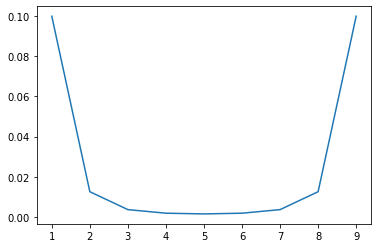

In [4]:
import matplotlib.pyplot as plt 
from scipy.special import binom 

def shap_kernel(z,p):
    #print(binom(p,z))
    #return binom(p,z)
    return (p-1)/(binom(p,z)*(z*(p-z)))
    #return (p-1)/(z*(p-z))
    
n_clients = 10
xx = list(range(1,n_clients))
scaling_factor = shap_kernel(1,n_clients)
print(scaling_factor)
print([shap_kernel(z,n_clients) for z in xx])
plt.plot(xx, [shap_kernel(z,n_clients) for z in xx])

In [5]:
class Net(nn.Module):
    def __init__(self,dataset,out=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        if dataset == 'FEMNIST':
            self.fc2 = nn.Linear(100, 62)
        if dataset == 'MNIST_niid':
            self.fc2 = nn.Linear(100,out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=-1)

In [6]:
from torch.utils.data import DataLoader
import copy
network = Net('MNIST_niid')
client_models = {}
optimizers = {}
dataloaders = {}
dataloaders_test = {}
for i in range(total_clients):
    client_models[str(i)] = copy.deepcopy(network).double().cuda()
    optimizers[str(i)] = torch.optim.SGD(client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
    dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
    dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
    dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
    dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [7]:
import random
# Select 5 clients 
selected_clients = [1,2,5,6] #[4,8,9]
# create a (random) graph between them
graph = []
for index,sample in enumerate(selected_clients):
    other_clients = copy.deepcopy(selected_clients)
    other_clients.remove(sample)
    l = [i for i in other_clients]
    graph.append(random.sample(l,k=2))
    
print(graph)

[[2, 6], [1, 6], [2, 1], [2, 1]]


In [8]:
class P2P_AFPL():
    def __init__(self,total_clients,train_data,train_partition,test_data,test_partition): 
        self.network = Net('MNIST_niid')
        self.total_clients = total_clients 
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.len = {}
        self.len_test = {}
        self.dataloaders_test = {}
        for i in range(total_clients):
            self.client_models[str(i)] = copy.deepcopy(network).double().cuda()
            self.optimizers[str(i)] = torch.optim.SGD(self.client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
            dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
            self.len[str(i)]= len(dataset_train)
            self.dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
            dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
            self.len_test[str(i)] = len(dataset_test)
            self.dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=False)
            
    def create_graph(self,selected_clients):
        graph = []
        for index,sample in enumerate(selected_clients):
            other_clients = copy.deepcopy(selected_clients)
            other_clients.remove(sample)
            l = [i for i in other_clients]
            graph.append(random.sample(l,k=2))

        return graph 
    
    def select_clients(self, n_clients=1,total_clients=1, seed=1):
        random.seed(seed)
        l = [i for i in range(total_clients)]
        self.selected_clients = random.sample(l,k=n_clients)
        return self.selected_clients 

    def update_local_models(self,selected_clients):
        self.dw = {}
        for idx,i in enumerate(selected_clients):
            #print("local model i",i)
            dataloader = self.dataloaders[str(i)]
            self.client_models[str(i)].train()
            
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                self.optimizers[str(i)].zero_grad()
                output = self.client_models[str(i)](data)
                loss = F.nll_loss(output,target)
                loss.backward()
                self.optimizers[str(i)].step()
            
            self.client_models[str(i)].eval()
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test += F.nll_loss(output,target)
            #print("loss test",loss_test)
            
            loss_test2 = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test2 += F.nll_loss(output,target)
            #print("loss train",loss_test2)
            
        return loss_test/self.len_test[str(i)],loss_test2 /self.len[str(i)]
    
    

            
    def combine_models(self,i,client_numbers):
        zero_copy = copy.deepcopy(self.client_models[str(i)]) # This is used to collect the model in
        j =0
        client_numbers_plus_client = client_numbers + [i] # This is more efficient
        alphas = zero_copy.alphas.detach()
        alphas[i] = 1 - torch.sum(
            torch.tensor([iii for idx, iii in enumerate(alphas) if idx != i and idx in client_numbers]))
        # It's not possible to set the value of self.alphas[i], so instead we determine it manually here

        for ii in client_numbers_plus_client:

            for (name, param),(name2,param2) in zip(zero_copy.named_parameters(),self.client_models[str(ii)].named_parameters()): #self.client_models[str(ii)].named_parameters()):

                if name != 'alphas':
                    if j == 0:
                        param.data = torch.zeros(param.shape).cuda()

                    param.data += alphas[ii]*param2.data # we add all participating client's models to the one here.

            j += 1

        self.client_models[str(i)] = zero_copy.double()
        
    def calc_accuracy(self):
        
        for i in self.selected_clients: 
            dataloader = self.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            print(i)
            print(accuracy)
            
    def federated_averaging(self):
        self.shared_model = copy.deepcopy(network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)
        #print("weights ",weight)
        for idx,i in enumerate(self.selected_clients): 
            for (name, param),(name2,param2) in zip(self.shared_model.named_parameters()
                                                      ,self.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 

        self.shared_model = self.shared_model.double()
        
    def init_models(self):
        for i in self.selected_clients: 
            for (name,param),(name2,param2) in zip(self.shared_model.named_parameters(),
                                                  self.client_models[str(i)].named_parameters()):
                param2.data = copy.deepcopy(param.data)
    
    def compare_favg(self):
        self.shared_model.eval()
        loss_before = []
        loss_after = []
        for ii in self.selected_clients:
            dataloader = self.dataloaders_test[str(ii)]
            loss_test = 0 
            loss_global = 0 
            #print("loss")
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()
#
                    output = self.client_models[str(ii)](data)
                    outputg = self.shared_model(data)
                    loss_test += F.nll_loss(output,target)
                    loss_global += F.nll_loss(outputg,target)
                     
            loss_before.append(loss_test.detach().cpu().numpy())
            loss_after.append(loss_global.detach().cpu().numpy())
        print("loss before: ",np.sum(loss_before))
        print("loss after: ",np.sum(loss_after))
    
    def loop(self,epochs,graph,mode='disjoint'):
        
        loss_tests = []
        loss_trains = []
        
        for i in range(epochs): 
            self.selected_clients = [0,1,2,3,4,5,6,7,8,9,10,11]
            list1 = []
            self.alphas = torch.ones(self.total_clients,self.total_clients)*(1/3)
            loss_test, loss_train = self.update_local_models(self.selected_clients)
            loss_tests.append(loss_test.detach().cpu().numpy())
            loss_trains.append(loss_train.detach().cpu().numpy())
            
            
            if i < epochs -1 :
                self.federated_averaging()
                self.compare_favg()
                self.init_models()
            else: 
                print("stopped fedavg")
            
        plt.plot(loss_tests,'r-')
        plt.plot(loss_trains,'k-')
        self.calc_accuracy()
        
          #  plt.imshow(data[0,0,:,:].detach().cpu().numpy())

loss before:  8.68615688999589
loss after:  252.35277496522392
loss before:  5.663124344771724
loss after:  110.04354455654695
loss before:  5.29240439938147
loss after:  62.741260506032646
loss before:  5.3374169763846275
loss after:  41.68177106068769
loss before:  5.046794888744813
loss after:  31.90839490017025
loss before:  4.349989935390459
loss after:  25.26190190909405
loss before:  4.133684494580142
loss after:  21.261082202192856
loss before:  3.354355097008957
loss after:  19.573334234631645
loss before:  3.2004499896486167
loss after:  17.150555858451572
stopped fedavg
0
98.7012987012987
1
100.0
2
100.0
3
99.21052631578947
4
99.74554707379136
5
100.0
6
100.0
7
98.82583170254404
8
100.0
9
100.0
10
99.74025974025975
11
99.61389961389962


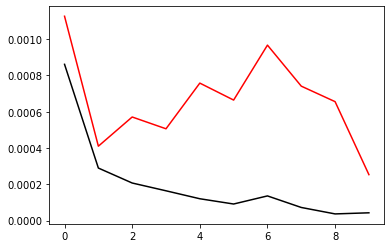

In [9]:
import collections
p2p = P2P_AFPL(total_clients,train_data,train_partition,test_data,test_partition)
alphas = p2p.loop(10,graph,p2p)


In [10]:
class calculate_SHAP(SHAP_kernel):
    def __init__(self,selected_clients,dataset,samples,p2p):
        super().__init__(len(selected_clients),samples,verbose=False)
        self.n_clients = len(selected_clients)
        self.samples = samples
        self.dataset = dataset
        self.selected_clients = selected_clients
        self.p2p = p2p 
        self.define_shap()
        
    def define_shap(self):
        # define Shap kernel
        #shap = SHAP_kernel(self.n_clients,self.samples,verbose=False)
        self.forward_shap()
        coalition_object = create_coalitions(self.adjusted,self.weights,self.n_clients)
        self.masks, self.weights = coalition_object.forward()
        
        self.masks = np.asarray(self.masks,dtype='bool')
        
    def combine_models(self,p2p,coalitions):
        shared_model = copy.deepcopy(p2p.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [p2p.len[str(x)] for x in coalitions]
        weight = weight / np.sum(weight) #weight is wrong 
        #print("weights ",weight)
        for idx,i in enumerate(coalitions): 
            for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                      ,p2p.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 
        shared_model = shared_model.double()
        return shared_model
        
    def solve(self,ey,fnull,maskMatrix,M,fx,dim,kernelWeights):
        eyAdj = ey[:, dim] - fnull[dim]
        s = np.sum(maskMatrix, 1)
        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(M)
        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
                    (fx[dim]) - (fnull[dim]))
        etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]])
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
        phi = np.zeros(M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((fx[dim]) - (fnull[dim])) - sum(w)
        # clean up any rounding errors
        for i in range(M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0
        return phi
    
    def calc_accuracy(self,model):
        
        for i in [10]: # we take subject 10 as test 
            dataloader = self.p2p.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = model(data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            #print(i)
            #print(accuracy)
            return accuracy 
        
    def forward(self,index,evaluation="loss"):
        #instance = self.dataset[index]
        k = 0 
        for batch_idx, (data, target) in enumerate(self.p2p.dataloaders_test[str(10)]):
                #instance[0]= data
                #target[0] = target
                for ii in range(len(target)):
                    
                    if k == index:
                        instance = (data[ii],target[ii])
                        #print(batch_idx*16 + ii)
                    k = k + 1 


        
        # calculate ey, output for all coalitions 
        ey= np.zeros((len(self.masks),1))
        for i,coalition in enumerate(self.masks): 
            selected_clients_coalition = np.concatenate((self.selected_clients[coalition],np.array([10])))
            #print(selected_clients_coalition)
            shared_model = self.combine_models(self.p2p,selected_clients_coalition)
            shared_model.eval().cuda()
            if evaluation == "loss":
                ey[i] = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
            else: 
                ey[i] = self.calc_accuracy(shared_model)
        ey = np.reshape(ey,(len(ey),1))
        self.ey = ey
        # calculate fnull, prediction without knowledge (empty initialized model)
        # we calculate the prediction of an untrained model 
        #self.p2p.client_models[str(0)].eval().cuda() #.double()
        shared_model = self.combine_models(self.p2p,np.array([0]))
        shared_model.eval().cuda()
        #p2p.network.eval().cuda().double()
        if evaluation == "loss":
            fnull = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
            #print("correct!")
        else: 
            fnull = self.calc_accuracy(p2p.network)
        fnull = np.reshape(fnull,(1,1))
       # print("untrained model: ",fnull)
        self.fnull = fnull 

        # calculate fx 
        shared_model = self.combine_models(self.p2p,np.concatenate((self.selected_clients,np.array([10]))))
        shared_model.eval().cuda()
        if evaluation == "loss": 
            fx = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        else: 
            fx = self.calc_accuracy(shared_model)
        fx = np.reshape(fx,(1,1))
        #print(fx)
        self.fx = fx 
        
        masks = np.asarray(self.masks,dtype = 'int')
        phi = self.solve(ey,fnull,masks,len(self.selected_clients),fx,0,self.weights)
        return phi 
    
    def forward2(self,evaluation="loss"):
        #ey= np.zeros((len(self.masks),len(p2p.dataloaders_test[str(10)])))
        ey = np.zeros((len(self.masks),p2p.len_test[str(10)]))
        # calculate ey, output for all coalitions 

        for i,coalition in enumerate(self.masks): 
            selected_clients_coalition = np.concatenate((self.selected_clients[coalition],np.array([10])))
            shared_model = self.combine_models(self.p2p,selected_clients_coalition)
            shared_model.eval().cuda()
            for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
                data = data.double().cuda()
                target = target.long().cuda()

                ey[i,batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
                
        #print(ey)

        # calculate fnull, prediction without knowledge (empty initialized model)
        # we calculate the prediction of an untrained model 
        #p2p.network.eval().cuda().double()
        shared_model = self.combine_models(self.p2p,np.array([10]))
        shared_model.eval().cuda()
        #fnull = np.zeros((len(p2p.dataloaders_test[str(10)]),1))
        fnull = np.zeros((p2p.len_test[str(10)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fnull[batch_idx*16:batch_idx*16+len(target)] = np.reshape(F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        
        #print(fnull)
        #print("untrained model: ",fnull)

        # calculate fx 
        selected_clients = np.concatenate((self.selected_clients,np.array([10])))
        shared_model = self.combine_models(self.p2p,selected_clients)
        shared_model.eval().cuda()
        #fx = np.zeros((len(p2p.dataloaders_test[str(10)]),1))
        fx = np.zeros((p2p.len_test[str(10)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fx[batch_idx*16:batch_idx*16 + len(target)] = np.reshape(F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        #print(fx)

        masks = np.asarray(self.masks,dtype = 'int')
        #phi = self.solve(ey,fnull,masks,len(self.selected_clients),fx,0,self.weights)
        return ey, fnull, fx , masks, self.weights
    
        
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])
samples = 200

phi_my_new = np.zeros((1,10))
for i in range(1):
    calc_shap = calculate_SHAP(selected_clients,p2p.dataloaders_test[str(10)],samples,p2p)
        

weights:  [0.43333333 0.07638889 0.07555556 0.07575758 0.07407407 0.07575758
 0.07555556 0.07638889 0.43333333]
we took:  199  samples instead of  200  samples
1.3961447811447811


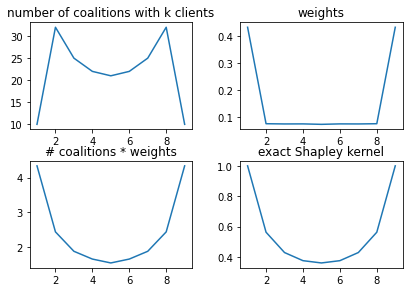

In [11]:
blub = SHAP_kernel(10,200,verbose=True)
blub.forward_shap()

In [12]:
from time import time 
print(len(p2p.dataloaders_test[str(10)]))
print(p2p.len_test[str(10)])
before = time()
calc_shap2 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
ey, fnull, fx , masks, weights = calc_shap2.forward2()
after = time() - before 
print(after)

25
385
8.288387537002563


(199, 385)
[0.00153147 0.03792704 0.02661943 0.08237015 0.03895835 0.03125873
 0.03165885 0.06845341 0.05733867 0.05416123]


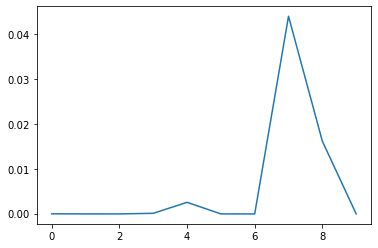

In [13]:
print(np.shape(ey))
plt.plot(ey[0:10,0]-fnull[0])
dub = np.zeros((345,10))
for i in range(345):
    #print(ey[0:10,0]-fnull[0])
    dub[i,:] = ey[0:10,i]-fnull[i]
print(np.mean(dub,axis=0))

[10. 32. 25. 22. 21. 22. 25. 32. 10.]
[ 1  7  8 11 11  8 18 23  9]
[1.         0.14285714 0.125      0.09090909 0.09090909 0.125
 0.05555556 0.04347826 0.11111111]


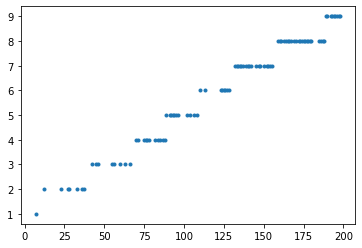

In [15]:
indices = np.argwhere(masks[:,7]==1)
#print(indices)
number = np.zeros(len(indices))
for j,index in enumerate(indices): 
    number[j] = np.sum(masks[index,:])
plt.plot(indices,number,'.')
print(calc_shap.discrete_shap)
unique, counts = np.unique(number,return_counts=True)
print(counts)
print(1/counts)
coalition_object = create_coalitions(calc_shap.adjusted,calc_shap.weights,calc_shap.n_clients)
masks2, weights2 = coalition_object.forward()

(199, 10)
(199,)



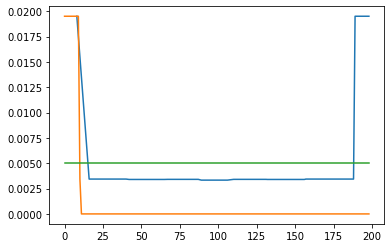

In [54]:
print(np.shape(masks))
#print(np.argwhere(masks[:,8]==1))
indices = np.argwhere(masks[:,8]==1)
plt.plot(indices,weights[indices])
#plt.plot(w[:200])
w_new = copy.deepcopy(weights[:199])
print(np.shape(w_new))
print()
w_new[11:] = 0 # weights[189:199]/10
plt.plot(w_new)
plt.plot(weights2[:199])

In [55]:
dub = np.zeros((385,10))
for i in range(385):
    #print(ey[0:10,0]-fnull[0])
    dub[i,:] = ey[189:,i]-fnull[i]
print(np.mean(dub,axis=0))

[0.09976436 0.18800118 0.19708146 0.10704339 0.10661598 0.09869893
 0.09589624 0.10868194 0.10641012 0.16823293]


In [57]:
print(np.sum(fx))
print(np.sum(fnull))

49.997436074395985
2.0041746437988315


[0.0195 0.0195 0.0195 0.0195 0.0195 0.0195 0.0195 0.0195 0.0195 0.0195]
(69252, 10)
(69252,)
(69252,)
[-0.03490324  0.02651316  0.01321022  0.04794335  0.02984588  0.02574859
  0.01900544 -0.03102835 -0.03966587  0.02785939]


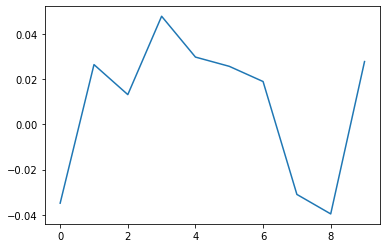

In [118]:
# Transform to k-dimensional least squares problem 
from sklearn.linear_model import LinearRegression
k = 348
dim = 0 
M = 10
maskMatrix = masks

#eyAdj = ey[dim,:] - fnull[dim]
#nonzero_inds = np.arange(M)
# eliminate one variable with the constraint that all features sum to the output
#eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
#            (fx[dim]) - (fnull[dim]))
eyAdjb = np.zeros((199*k))
eyAdj2b = np.zeros((199*k))
#print(np.shape(ey.T))
for kk in range(k): 
    #print(np.shape(ey[kk,:] -fnull_array[kk]))
    eyAdjb[kk*199:(kk+1)*199] = ey[:,kk] -fnull[kk]
    
    nonzero_inds = np.arange(M)
# eliminate one variable with the constraint that all features sum to the output
    #eyAdj2b[kk*199:(kk+1)*199] = eyAdjb[kk*199:(kk+1)*199] - maskMatrix[:, nonzero_inds[-1]] * (
    #        (fx_array[kk]) - (fnull_array[kk]))
    eyAdj2b[kk*199:(kk+1)*199] = eyAdjb[kk*199:(kk+1)*199] #/ np.sum(eyAdjb[kk*199:(kk+1)*199])
    
    
#etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]]) # this is our x
etmp = maskMatrix #np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:]]))
X = np.tile(etmp, (k,1))
y = eyAdj2b 
#w = np.tile(weights2[:199], k)
w = np.tile(weights[:199], k)
#w = np.tile(w_new[:199], k)
print(w[189:199])
print(np.shape(X))
print(np.shape(y))
print(np.shape(w))
#print(y)
reg = LinearRegression(fit_intercept=False).fit(X,y,sample_weight=w)
phi_raw2 = reg.coef_ 
print(phi_raw2)
plt.plot(phi_raw2)


[False False False ...  True  True  True]
[-0.03975597  0.03663788  0.02132678  0.05724319  0.02851445  0.03425849
  0.02666975 -0.04766672 -0.05121897  0.03566545]


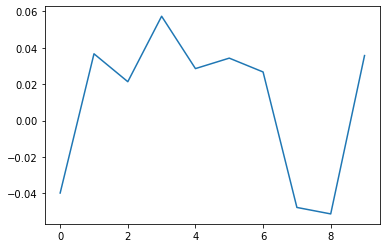

In [154]:
print(eyAdjb>0)
#plt.plot(eyAdjb[eyAdjb<0])

reg = LinearRegression(fit_intercept=False).fit(X[eyAdjb>0],y[eyAdjb>0],sample_weight=w[eyAdjb>0])
phi_raw2 = reg.coef_ 
print(phi_raw2)
plt.plot(phi_raw2)

In [160]:
print(np.sum(fnull))
print(len(fnull))
print(np.shape(ey))
print(np.sum(ey[:10,:],axis=1))

2.0041746437988315
385
(199, 385)
[ 2.85067561 34.23242731 28.46502853 57.77997824 42.66504333 31.44413806
 31.63388345 26.40855657 23.37118121 41.93235146]


In [165]:
shared_model = calc_shap2.combine_models(p2p,[0])
shared_model.eval().cuda()
ey2 = np.zeros(384)
for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
    data = data.double().cuda()
    target = target.long().cuda()

    ey2[batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
print(np.sum(ey2))

5.814358681478112


In [162]:
print(np.sum(ey2))

2.8506505047278092


[10. 32. 25. 22. 21. 22. 25. 32. 10.]
[ 10.  42.  67.  89. 110. 132. 157. 189. 199.]
[  0.  10.  42.  67.  89. 110. 132. 157. 189. 199.]
[0.08332033 0.11652203 0.1735685  0.09663771 0.16963868 0.14690778
 0.1395162  0.14554028 0.1328483 ]
0.00520564842545151


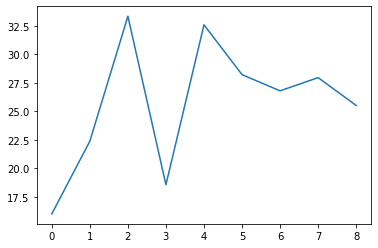

In [108]:
print(calc_shap.discrete_shap)
print(np.cumsum(calc_shap.discrete_shap))
blub = np.cumsum(calc_shap.discrete_shap)
blub = np.concatenate(([0],blub))
print(blub)
result = np.zeros(9)
for i in range(9): # look at the performance improvement/decrease when using i clients 
    result[i] = np.mean(ey[int(blub[i]):int(blub[i+1]),:])
print(result)
print(np.mean(fnull))
plt.plot(result/np.mean(fnull))

0.00520564842545151
0.12986347032310647


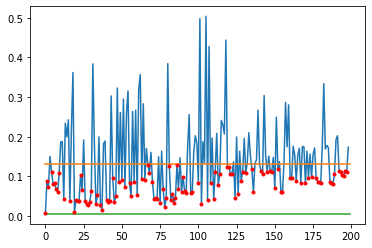

In [151]:
#plt.plot(np.mean(ey,axis=1))
#plt.plot(np.repeat(np.mean(fnull),200))
# 
print(np.mean(fnull))
print(np.mean(fx))
new_weights = np.abs(np.mean(ey,axis=1))
plt.plot(new_weights)
plt.plot(np.repeat(np.mean(fx),200))
plt.plot(np.repeat(np.mean(fnull),200))
indices = np.where(np.mean(ey,axis=1) <np.repeat(np.mean(fx),199))
plt.plot(indices[0],new_weights[indices],'.r')

In [153]:
print(np.shape(indices))

(1, 113)


In [147]:
index = []
indices = np.ravel(indices)
for i in range(340):
    indices = indices + np.repeat(199*i,len(indices))
    index.append(indices)

In [150]:
index = np.array(index)
print(np.shape(index))
index = np.ravel(index)
print(np.shape(index))
print(index[:300])

(38420,)
(38420,)
[  0   1   2   4   5   6   7   8   9  12  16  19  20  21  22  23  24  26
  27  28  29  30  33  34  36  37  40  41  42  44  45  46  48  50  52  55
  56  58  60  63  65  67  68  70  71  72  73  75  77  78  79  81  82  83
  84  85  86  87  89  90  91  92  95  96 100 102 106 108 110 111 113 114
 119 120 121 122 124 126 128 129 131 135 136 141 142 145 147 148 150 152
 154 155 160 161 164 167 170 172 174 177 178 179 180 186 187 188 189 192
 193 194 195 196 197 199 200 201 203 204 205 206 207 208 211 215 218 219
 220 221 222 223 225 226 227 228 229 232 233 235 236 239 240 241 243 244
 245 247 249 251 254 255 257 259 262 264 266 267 269 270 271 272 274 276
 277 278 280 281 282 283 284 285 286 288 289 290 291 294 295 299 301 305
 307 309 310 312 313 318 319 320 321 323 325 327 328 330 334 335 340 341
 344 346 347 349 351 353 354 359 360 363 366 369 371 373 376 377 378 379
 385 386 387 388 391 392 393 394 395 396 597 598 599 601 602 603 604 605
 606 609 613 616 617 618 619 620 

[-0.00165121 -0.00106648 -0.00200146 -0.00160478  0.00185845 -0.00101729
 -0.00186642  0.00714681  0.00320638 -0.00129823]


IndexError: index 69849 is out of bounds for axis 0 with size 69252

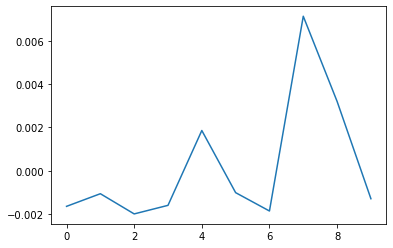

In [149]:
reg = LinearRegression(fit_intercept=False).fit(X[:199],y[:199],sample_weight=w[:199])
phi_raw2 = reg.coef_ 
print(phi_raw2)
plt.plot(phi_raw2)
reg = LinearRegression(fit_intercept=False).fit(X[index],y[index],sample_weight=w[index])
phi_raw2 = reg.coef_ 
print(phi_raw2)
plt.plot(phi_raw2)

(199, 385)
(385, 1)


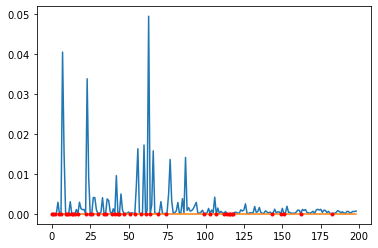

In [79]:
print(np.shape(ey))
print(np.shape(fnull))
plt.plot(ey[:,1])
plt.plot(np.repeat(fnull[1],199))
better = ey[:,1] < fnull[1]
indices = np.where(ey[:,1]<fnull[1])
plt.plot(indices[0],ey[better,1],'r.')

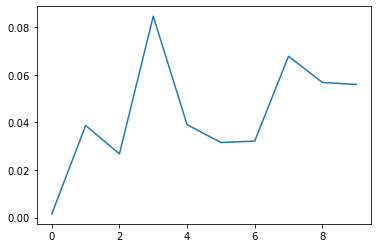

In [59]:
# look at the first 10 coalitions 
ys = np.zeros((348,10))
for j in range(348):
    ys[j,:] = y[199*j:199*j+10]

sumphi = np.mean(ys,axis=0)
plt.plot(sumphi)

[0.4413011  0.4760204  0.47428472 0.48551054 0.47837057 0.47544467
 0.47511707 0.41894146 0.42095359 0.48263324]
[[1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1]]


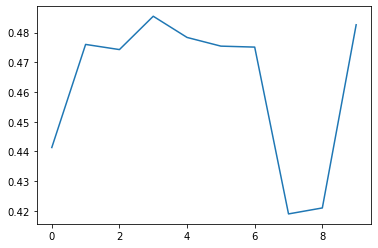

In [60]:
# look at the last 10 coalitions 
ys = np.zeros((348,10))
for j in range(348):
    ys[j,:] = y[199*j+189:199*j+199]

sumphi = np.mean(ys,axis=0)
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])
sump = np.zeros(10)
for i in range(len(selected_clients)):
    selected_clients_2 = np.delete(selected_clients,i)
    sump[9-i] = np.sum(sumphi[selected_clients_2])
print(sump)
plt.plot(sump)
print(masks[189:199,:])

In [ ]:
# show that this mainly has to do with the misclassification of 2's. 


In [48]:
plt.plot(np.mean(phis_single2,axis=0))

NameError: name 'phis_single2' is not defined

In [69]:
print(np.shape(ey))
print(np.shape(fnull))
print(np.shape(fx))
print(np.shape(masks))
print(np.shape(weights))

(199, 385)
(385, 1)
(385, 1)
(199, 10)
(199,)


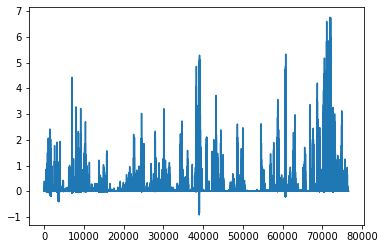

In [119]:
plt.plot(eyAdjb)

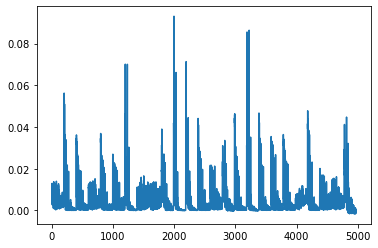

In [30]:
plt.plot(eyAdj2b)

In [108]:
from time import time 
# calculate 'ground truth' SV based on only one sample 
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])

samples = 1022
calc_shap = calculate_SHAP(selected_clients,dataset_train,samples,p2p)
#calc_shap2 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
# calculate phi value for 100 random samples in the train dataset 
print(len(dataset_train))
indices = np.random.randint(348,size=100)

# do this for 10 clients: 
phis_single2 = np.zeros((100,10))
fnull_array = np.zeros(100)
fx_array = np.zeros(100)
ey_array = np.zeros((100,199))
for j,i in enumerate(indices): 
#for i in indices:
    print(j)
    phi_gt_single2 = calc_shap2.forward(i,evaluation="loss")
    fnull_array[j] = calc_shap2.fnull
    fx_array[j] = calc_shap2.fx
    phis_single2[j,:] = phi_gt_single2#/np.sum(phi_gt_single2)
    ey_array[j,:] = np.ravel(calc_shap2.ey)


1583
0


/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


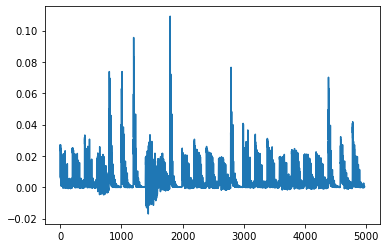

In [138]:
plt.plot(y)

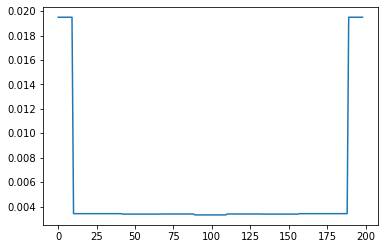

In [139]:
plt.plot(calc_shap2.weights)

In [82]:
dim = 0
M = 10 
maskMatrix = np.asarray(calc_shap2.masks,dtype = 'int')
eyAdj = ey[dim,:] - fnull_array[dim]
print(np.shape(eyAdj)) # this is our y 
s = np.sum(maskMatrix, 1)
# do feature selection if we have not well enumerated the space
nonzero_inds = np.arange(M)
# eliminate one variable with the constraint that all features sum to the output
eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
            (fx_array[dim]) - (fnull_array[dim]))
etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]]) # this is our x



(199,)


In [83]:
print(np.shape(ey[dim,:]))

(199,)


(199, 9)
(199,)
(199,)
[-0.03823057  0.01365829  0.01032824 -0.03841841  0.01044364  0.00292917
  0.01275646  0.00647827  0.01105955  0.00881592]
[ 2.84122588e-05 -9.50978280e-05 -1.47165710e-05  1.97944806e-06
 -2.43449045e-05  1.31015823e-05 -7.20295803e-05  8.06776010e-06
  1.11937203e-05 -3.60065538e-05]
[-0.03588396  0.00968889  0.0093388  -0.0368585   0.01381635  0.00304845
  0.01084023  0.00907289  0.01001535  0.00674205]
[-0.03588396  0.00968889  0.0093388  -0.0368585   0.01381635  0.00304845
  0.01084023  0.00907289  0.01001535]


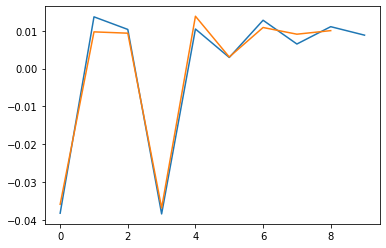

In [88]:
from sklearn.linear_model import LinearRegression
X = etmp 
y = eyAdj2
w = calc_shap2.weights
print(np.shape(X))
print(np.shape(y))
print(np.shape(w))

reg  = LinearRegression().fit(X,y,sample_weight=w)
phi_raw = reg.coef_ 
phi = np.zeros(M)
phi[nonzero_inds[:-1]] = phi_raw
phi[nonzero_inds[-1]] = ((fx_array[dim]) - (fnull_array[dim])) - sum(phi_raw)
#print(reg.coef_)
print(phi)
print(phis_single2[dim,:])
phi3 = calc_shap2.solve(np.reshape(ey[dim],(199,1)),np.reshape(fnull_array[dim],(1,1))
                        ,maskMatrix,10,np.reshape(fx_array[dim],(1,1)),dim,w)
print(phi3)
#plt.plot(X[:,0],y,".")
tmp = np.transpose(np.transpose(etmp) * np.transpose(w))
#print("tmp ",np.shape(tmp))
etmp_dot = np.dot(np.transpose(tmp), etmp)

tmp2 = np.linalg.inv(etmp_dot)
phi4 = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
print(phi4)
plt.plot(phi)
plt.plot(phi4)
    

[ 2.84122588e-05 -9.50978280e-05 -1.47165710e-05  1.97944806e-06
 -2.43449045e-05  1.31015823e-05 -7.20295803e-05  8.06776010e-06
  1.11937203e-05]


/local/tmp.856566/ipykernel_3396731/1983699831.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  aaa= np.linalg.lstsq(Xw,yw)


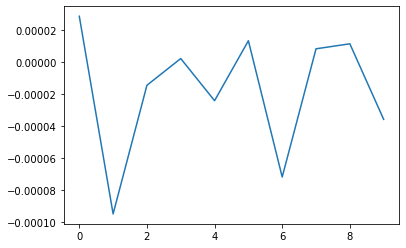

In [63]:
W = np.sqrt(np.diag(w))
Xw = np.dot(W,X)
yw = np.dot(y,W)
aaa= np.linalg.lstsq(Xw,yw)
print(aaa[0])
phi5 = np.zeros(M)
phi5[nonzero_inds[:-1]] = aaa[0]
phi5[nonzero_inds[-1]] = ((fx_array[dim]) - (fnull_array[dim])) - sum(aaa[0])
plt.plot(phi5)

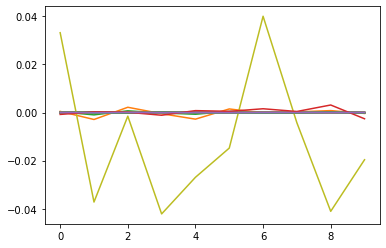

In [17]:
plt.plot(phis_single2.T);

In [ ]:
def solve(ey,fnull,maskMatrix,M,fx,dim,kernelWeights):
        eyAdj = ey[:, dim] - fnull[dim]
        s = np.sum(maskMatrix, 1)
        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(M)
        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
                    (fx[dim]) - (fnull[dim]))
        etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]])
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
        phi = np.zeros(M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((fx[dim]) - (fnull[dim])) - sum(w)
        # clean up any rounding errors
        for i in range(M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0
        return phi

In [14]:
print(calc_shap2.ey[:10])
print(calc_shap2.fnull)
print(np.shape(calc_shap2.masks))

[[2.40657901e-04]
 [5.41295804e-05]
 [1.49001047e-04]
 [1.40331342e-04]
 [1.10599015e-04]
 [1.63053622e-04]
 [6.85992683e-05]
 [1.75397149e-04]
 [2.38669760e-04]
 [1.34973161e-04]]
[[0.00011899]]
[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [ True  True False ...  True  True  True]
 [ True False  True ...  True  True  True]
 [False  True  True ...  True  True  True]]


In [116]:
print(calc_shap2.fnull)
print(calc_shap2.fx)
#print(np.sum(phis_single[24,:]))
#print(calc_shap2.fx + np.sum(phis_single[24,:]))
#print(phis_single[24,:])
shared_model = calc_shap2.combine_models(p2p,np.array([0,10]))
shared_model2 = calc_shap2.combine_models(p2p,np.array([10]))
shared_model3 = calc_shap2.combine_models(p2p,np.array([0,8,10]))
shared_model.eval()
shared_model2.eval()
shared_model3.eval()

f_null = 0 
f_opt = 0 
f_opt3 = 0 
fx = np.zeros((348,1))
fnull = np.zeros((348,1))
#fopt = np.zeros((385,1))
#fopt3 = np.zeros((385,1))
phi_gt_single = np.zeros((348,10))
k = 0 
for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
    for ii in range(len(target)):
        instance = (data[ii],target[ii])
        print(k)
#print(data[0][0][6])
        #f_null += F.nll_loss(shared_model2(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        #f_opt += F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        #f_opt3 += F.nll_loss(shared_model3(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        #fopt3[k]= F.nll_loss(shared_model3(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()

    #print(np.shape(calc_shap2.forward(k,evaluation="loss")))
        
        phi_gt_single[k,:] =calc_shap2.forward(k,evaluation="loss")
        #fopt[k] = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        #fopt2[k] = F.nll_loss(shared_model3(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        
        
        fnull[k] = calc_shap2.fnull
        fx[k] = calc_shap2.fx
        #
        k += 1 
print(f_null)
print(f_opt)


[[0.00018254]]
[[0.00049803]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


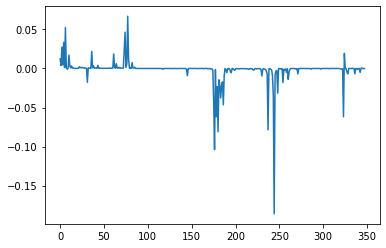

In [127]:
plt.plot(fx-fnull)

In [93]:
phi_gt_normalized = np.zeros((385,10))
phi_gt_normalized2 = np.zeros((385,10))
phi_gt_normalized3 = np.zeros((385,10))
for i in range(385):
    #print(phi_gt_single[i,:])
    phi_gt_normalized[i,:] = phi_gt_single[i,:] - np.mean(phi_gt_single[i,:])
   # print(phi_gt_normalized[i,:])
    phi_gt_normalized[i,:] = phi_gt_normalized[i,:]/np.sum(np.abs(phi_gt_normalized[i,:]))*fnull[i]
    phi_gt_normalized2[i,:] = phi_gt_single[i,:]/(fx[i]-fnull[i]) #np.sum(np.abs(phi_gt_single[i,:]))
    phi_gt_normalized3[i,:] = phi_gt_single[i,:]/np.mean(phi_gt_single[i,:])


In [119]:
# instead of normalizing, just count how often participating with this client would bring the loss down. 
phi_count = np.zeros((348,10))
#epsilon = -0.0001
phi_benefit = np.zeros((348,10))
phi_loss = np.zeros((348,10))

for i in range(348): 
    negative_indices = phi_gt_single[i,:] < 0 + epsilon
    positive_indices = phi_gt_single[i,:] >= 0 + epsilon  
    
    phi_count[i,negative_indices] = 1 
    phi_benefit[i,negative_indices] = -fnull[i]#phi_gt_single[i,negative_indices]
    phi_loss[i,positive_indices] = fnull[i]#phi_gt_single[i,positive_indices]
print(np.sum(phi_count,axis=0))

[ 60. 134.  99. 110.  57.   7.  65.  67.  34.  31.]


In [159]:
print(phi_gt_single[1,:10])
print(phi_gt_single[1,:10]-fnull[1])

[ 1.13943295e-04 -1.01335310e-03 -1.25959046e-03 -4.16405192e-04
  3.22309484e-04  1.36391200e-03  2.64272355e-03  4.84018235e-04
 -7.89925213e-05  1.63336081e-03]
[-0.00664493 -0.00777223 -0.00801847 -0.00717528 -0.00643657 -0.00539496
 -0.00411615 -0.00627486 -0.00683787 -0.00512551]


[-0.00030872 -0.00103559 -0.0008804  -0.0002291  -0.00010011  0.00039628
  0.00022679 -0.00051813  0.00012661  0.00044232]


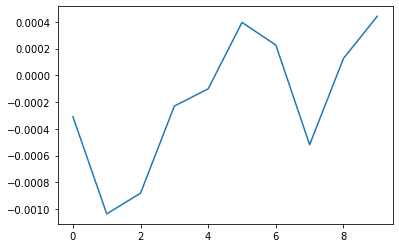

In [154]:
plt.plot(np.mean(phi_gt_single,axis=0))
print(np.mean(phi_gt_single,axis=0))

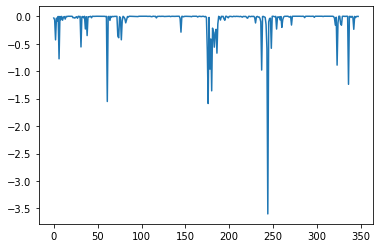

In [151]:
plt.plot(np.sum(phi_gt_single-fnull,axis=1))

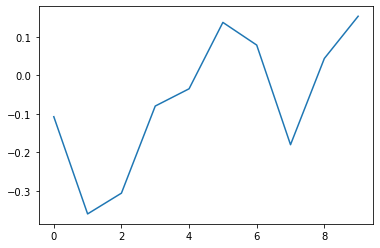

In [148]:
plt.plot(np.sum(phi_gt_single,axis=0))

[-2.06714928e-05 -6.92974299e-05 -5.21781969e-05  6.46456379e-06
  5.26995430e-06  2.66146703e-05  3.32431905e-05 -2.00830990e-05
  4.23328815e-06  3.72279310e-05]


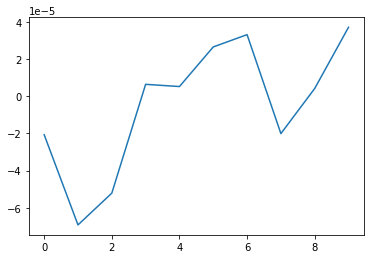

In [147]:
plt.plot(np.mean(phi_gt_single*fx,axis=0))
print(np.mean(phi_gt_single*fx,axis=0))

[-1.9127335  -2.19326149 -2.12134431 -1.99598699 -1.76123688 -0.22955995
 -1.70582829 -1.66784456 -1.58146774 -1.39929049]
[0.54074575 0.26021776 0.33213494 0.45749226 0.69224237 2.2239193
 0.74765096 0.78563469 0.87201151 1.05418876]
[-1.37198774 -1.93304372 -1.78920937 -1.53849473 -1.0689945   1.99435935
 -0.95817733 -0.88220987 -0.70945623 -0.34510173]


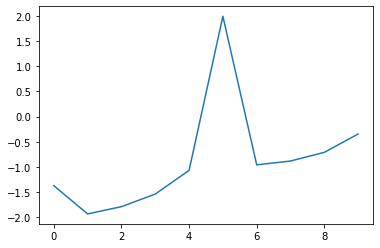

In [121]:
print(np.sum(phi_benefit,axis=0))
print(np.sum(phi_loss,axis=0))
print(np.sum(phi_benefit,axis=0) + np.sum(phi_loss,axis=0))
plt.plot(np.sum(phi_benefit,axis=0) + np.sum(phi_loss,axis=0))

In [146]:
initial_model = calc_shap2.combine_models(p2p,np.array([10]))

shared_model = calc_shap2.combine_models(p2p,np.array([0,1,2,3,4,5,6,7,8,9,10]))
shared_model2 = calc_shap.combine_models(p2p,np.array([0,1,2,3,7,10]))
shared_model3 = calc_shap.combine_models(p2p,np.array([1,2,3,10]))
#shared_model3 = calc_shap2.combine_models(p2p,np.array([0,1,2,3,4,6,7,8,9,10]))
shared_model.eval()
shared_model2.eval()
shared_model3.eval()

f_null = 0 
f_opt = 0 
f_opt2 = 0 
f_opt3 = 0 

k = 0 
for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
    for ii in range(len(target)):
        instance = (data[ii],target[ii])

        f_null += F.nll_loss(initial_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt += F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt2 += F.nll_loss(shared_model2(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt3 += F.nll_loss(shared_model3(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()

        k += 1 
print(f_null)
print(f_opt)
print(f_opt2)
print(f_opt3)

5.739251866123742
1.7992195154017812
1.4799153831717595
1.4789712477724615
